### Lab 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext
# ! pip install spacy
# ! pip install torchnlp

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = './data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

In [3]:
if not os.path.exists('./utils.py'):
    print("utils file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/utils.py -nc

if not os.path.exists('./my_network.py'):
    print("network file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/homeworks/Lab02_NMT/my_network.py -nc

In [4]:
import random
import math
import time

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tqdm

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from nltk.translate.bleu_score import corpus_bleu
from utils import get_text, remove_tech_tokens
from utils_ext import generate_translation_ext

from model1 import LstmEncoder, AttentionLstmDecoder, AttentionLstmSeq2Seq

model_name = 'model2.pt'

SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [5]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [6]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [7]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05], random_state=random.seed(SEED))

In [8]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [9]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [10]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9256
Unique tokens in target (en) vocabulary: 6734


Here are tokens from original (RU) corpus:

In [11]:
SRC.vocab.itos[::1000]

['<unk>',
 'террасу',
 'чистые',
 'компьютеры',
 'don',
 'шамони',
 'logis',
 'форму',
 'душевые',
 'техасского']

And from target (EN) corpus:

In [12]:
TRG.vocab.itos[::1000]

['<unk>', 'springs', 'galeao', 'calm', 'occupies', 'tegel', 'malioboro']

And here is example from train dataset:

In [13]:
print(vars(train_data.examples[9]))

{'trg': ['other', 'facilities', 'offered', 'at', 'the', 'property', 'include', 'grocery', 'deliveries', ',', 'laundry', 'and', 'ironing', 'services', '.'], 'src': ['также', 'предлагается', 'доставка', 'продуктов', ',', 'услуги', 'прачечной', 'и', 'гладильные', 'услуги', '.']}


Let's check the length distributions:

Length distribution in Train data


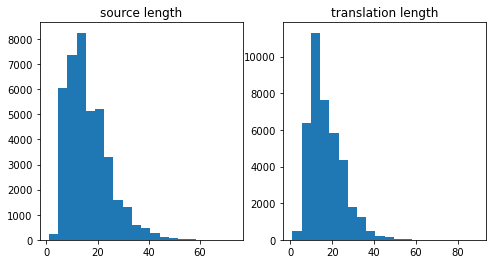

In [14]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


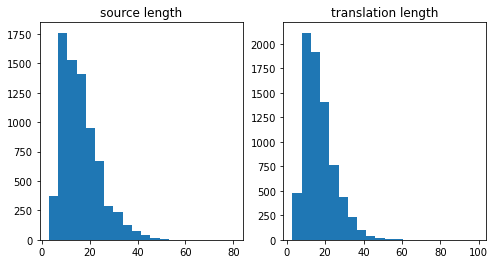

In [15]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [18]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 58x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 75x128 (GPU 0)]
torch.Size([75, 128]) torch.Size([58, 128])


In [19]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 3
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

LR = 1e-3
N_EPOCHS = 10
CLIP = 3.

enc = LstmEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = AttentionLstmDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = AttentionLstmSeq2Seq(enc, dec, device).to(device)

In [20]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

AttentionLstmSeq2Seq(
  (encoder): LstmEncoder(
    (embedding): Embedding(9256, 256)
    (rnn): LSTM(256, 512, num_layers=3, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttentionLstmDecoder(
    (embedding): Embedding(6734, 256)
    (attention): Attention(
      (linear_in): Linear(in_features=1536, out_features=1536, bias=False)
      (linear_out): Linear(in_features=3072, out_features=1536, bias=False)
      (softmax): Softmax(dim=-1)
      (tanh): Tanh()
    )
    (rnn): LSTM(256, 512, num_layers=3, dropout=0.5)
    (out): Linear(in_features=1536, out_features=6734, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 33,080,398 trainable parameters


In [22]:
PAD_IDX = TRG.vocab.stoi['<pad>']

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.001, amsgrad=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=2)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [23]:
def train(model: AttentionLstmSeq2Seq, iterator, optimizer, criterion,
          clip, epoch: int, train_history=None, valid_history=None, 
          train_bleu_history=None, val_bleu_history=None):

    model.train()
    
    epoch_loss = 0
    history = []

    teacher_forcing_ratio = 0.85 ** (epoch * 0.7  + 1)

    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model.forward(src, trg, teacher_forcing_ratio)
        
        output = output[1:].view(-1, output.shape[-1]) # [(trg sent len - 1) * batch size, output dim]
        trg = trg[1:].view(-1) # [(trg sent len - 1) * batch size]
        
        loss = criterion(output, trg)
        loss.backward()
        
        # Let's clip the gradient
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%50==0:
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            if train_bleu_history is not None:
                ax[2].plot(train_bleu_history, label='train BLEU history')
            if val_bleu_history is not None:
                ax[2].plot(val_bleu_history, label='validate BLEU history')

            ax[1].set_xlabel('Epoch')
            ax[1].set_title('Validation loss')

            ax[2].set_xlabel('Epoch')
            ax[2].set_title('BLEU')
                
            plt.legend()
            plt.show()

        
    return epoch_loss / len(iterator)

In [24]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            output = output[1:].view(-1, output.shape[-1]) # [(trg sent len - 1) * batch size]
            trg = trg[1:].view(-1) # [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)


In [25]:
def calc_bleu(model, iterator, hidden_tqdm = False):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for i, batch in tqdm.tqdm(enumerate(iterator), disable=hidden_tqdm):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            output = output.argmax(dim=-1)

            original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
            generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])
            
    return corpus_bleu([[text] for text in original_text], generated_text) * 100

In [26]:
def epoch_time(start_time, end_time, epoch: int=1):
    elapsed_time = (end_time - start_time) / epoch
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

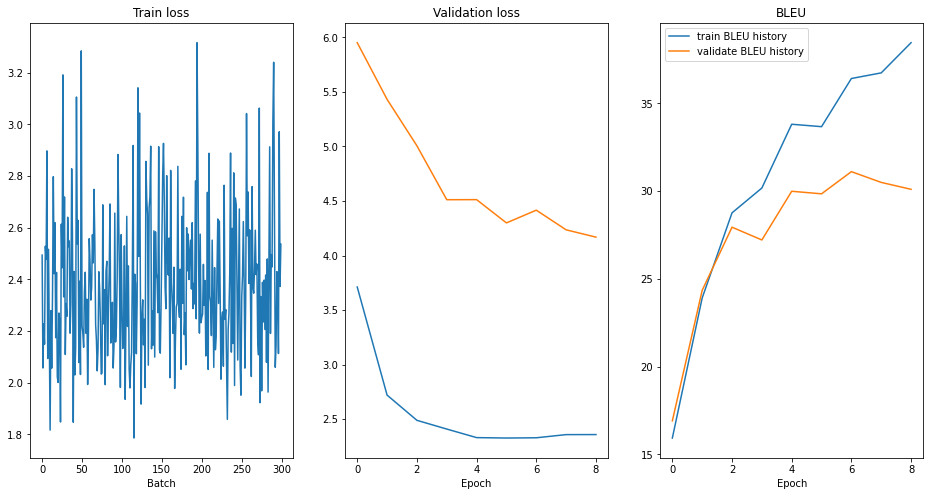

Total epohs: 10
Total train time: Time: 37m 27s
Average epoch train time: 3m 44s
Best BLEU:  31.104


In [27]:
train_history = []
valid_history = []
train_bleu_history = []
val_bleu_history = []

best_valid_bleu = float('-inf')

start_time = time.time()

for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, epoch,
                       train_history, valid_history, train_bleu_history, val_bleu_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    train_bleu = calc_bleu(model, train_iterator, hidden_tqdm=True)
    valid_bleu = calc_bleu(model, valid_iterator, hidden_tqdm=True)
    if valid_bleu > best_valid_bleu:
        best_valid_bleu = valid_bleu
        torch.save(model.state_dict(), model_name)
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    train_bleu_history.append(train_bleu)
    val_bleu_history.append(valid_bleu)

end_time = time.time()

print(f'Total epohs: {epoch+1:02}')

epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'Total train time: Time: {epoch_mins}m {epoch_secs}s')

epoch_mins, epoch_secs = epoch_time(start_time, end_time, N_EPOCHS)
print(f'Average epoch train time: {epoch_mins}m {epoch_secs}s')

print(f'Best BLEU: {best_valid_bleu:7.3f}')

__Let's take a look at our network quality__:

In [28]:
enc = LstmEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = AttentionLstmDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = AttentionLstmSeq2Seq(enc, dec, device).to(device)

model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [29]:
batch = next(iter(test_iterator))
for idx in range(50, 55):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation_ext(src, trg, model, SRC.vocab, TRG.vocab)

Original:	обустроена бесплатная частная парковка .
Translation:	free private parking is also available at this apartment .
Generated:	free private parking is available .

Original:	предоставляются также услуги прачечной .
Translation:	laundry service is available here .
Generated:	laundry service is available .

Original:	ванная комната — общая .
Translation:	all rooms include a shared bathroom .
Generated:	the bathroom is a .

Original:	неподалеку оборудована бесплатная парковка .
Translation:	free parking is possible nearby .
Generated:	free parking is possible nearby .

Original:	в числе удобств телевизор .
Translation:	a tv is provided .
Generated:	accommodation will a tv .



In [30]:
calc_bleu(model, test_iterator)

59it [00:05, 10.95it/s]


29.63624316840301

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points